<a href="https://colab.research.google.com/github/ipeirotis/datasets/blob/master/notebooks/DOH_Restaurant_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf 

In [1]:
!sudo pip install pandas-profiling[notebook]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download Latest Dataset

In [2]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  114M    0  114M    0     0  7921k      0 --:--:--  0:00:14 --:--:-- 8401k


In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [4]:
initial_size = len(df)
initial_size

274701

In [5]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE DESCRIPTION      object
INSPECTION DATE          object
ACTION                   object
VIOLATION CODE           object
VIOLATION DESCRIPTION    object
CRITICAL FLAG            object
SCORE                    object
GRADE                    object
GRADE DATE               object
RECORD DATE              object
INSPECTION TYPE          object
Latitude                 object
Longitude                object
Community Board          object
Council District         object
Census Tract             object
BIN                      object
BBL                      object
NTA                      object
dtype: object

In [7]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [8]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE_DESCRIPTION      object
INSPECTION_DATE          object
ACTION                   object
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
CRITICAL_FLAG            object
SCORE                    object
GRADE                    object
GRADE_DATE               object
RECORD_DATE              object
INSPECTION_TYPE          object
LATITUDE                 object
LONGITUDE                object
COMMUNITY_BOARD          object
COUNCIL_DISTRICT         object
CENSUS_TRACT             object
BIN                      object
BBL                      object
NTA                      object
dtype: object

## Cleaning Individual Columns

In [9]:
df.CAMIS.isnull().sum()

0

In [10]:
df.DBA.isnull().sum()

1507

In [11]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [12]:
df.INSPECTION_TYPE.value_counts()

Cycle Inspection / Initial Inspection                          160400
Cycle Inspection / Re-inspection                                54254
Pre-permit (Operational) / Initial Inspection                   28148
Pre-permit (Operational) / Re-inspection                        10480
Administrative Miscellaneous / Initial Inspection                5013
Pre-permit (Non-operational) / Initial Inspection                2523
Cycle Inspection / Reopening Inspection                          2437
Smoke-Free Air Act / Initial Inspection                          1122
Pre-permit (Operational) / Compliance Inspection                 1103
Administrative Miscellaneous / Re-inspection                     1021
Pre-permit (Operational) / Reopening Inspection                   914
Inter-Agency Task Force / Initial Inspection                      842
Trans Fat / Initial Inspection                                    748
Cycle Inspection / Compliance Inspection                          384
Calorie Posting / In

In [13]:
sum(df.INSPECTION_TYPE.isnull())

4067

In [14]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [15]:
sum(df['TO_DELETE'])

4067

In [16]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [17]:
t[0].value_counts()

Cycle Inspection                217479
Pre-permit (Operational)         40721
Administrative Miscellaneous      6146
                                  4067
Pre-permit (Non-operational)      2773
Smoke-Free Air Act                1381
Trans Fat                          896
Inter-Agency Task Force            842
Calorie Posting                    396
Name: 0, dtype: int64

In [18]:
t[1].value_counts()

Initial Inspection              199145
Re-inspection                    66381
                                  4067
Reopening Inspection              3395
Compliance Inspection             1594
Second Compliance Inspection        90
Limited Inspection                  29
Name: 1, dtype: int64

In [19]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [20]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

60047

In [21]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the 
# additional condition
df['TO_DELETE'] |= ~keep

In [22]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

In [23]:
sum(df['TO_DELETE'])

60047

### BORO

In [24]:
df.BORO.value_counts()

Manhattan        105771
Brooklyn          67587
Queens            65566
Bronx             26910
Staten Island      8793
0                    74
Name: BORO, dtype: int64

In [25]:
sum(df.BORO.isnull())

0

In [26]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [27]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [28]:
sum(df.BORO == '0')

74

In [29]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [30]:
sum(df['TO_DELETE'])

60085

### BUILDING

In [31]:
sum(df.BUILDING.isnull())

652

In [32]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [33]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [34]:
sum(df['TO_DELETE'])

60617

### STREET

In [35]:
# Check that no street values are empty
sum(df.STREET.isnull())

27

In [36]:
df['TO_DELETE'] |= df.STREET.isnull()

In [37]:
sum(df['TO_DELETE'])

60617

### ZIPCODE

In [38]:
sum(df.ZIPCODE.isnull())

3973

In [39]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

472

In [40]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [41]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [42]:
df.CUISINE_DESCRIPTION.value_counts()

American          50882
Chinese           27701
Pizza             16590
Coffee/Tea        13156
Latin American    11698
                  ...  
Czech                18
Basque               10
Lebanese              9
New French            6
Armenian              3
Name: CUISINE_DESCRIPTION, Length: 87, dtype: int64

In [43]:
len(df.CUISINE_DESCRIPTION.value_counts())

87

In [44]:
sum(df.CUISINE_DESCRIPTION.isnull())

4067

In [45]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [46]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [47]:
df.INSPECTION_DATE.describe(datetime_is_numeric=True)

count                           274701
mean     2018-04-03 22:29:17.794838784
min                1900-01-01 00:00:00
25%                2019-02-20 00:00:00
50%                2019-09-24 00:00:00
75%                2021-08-23 00:00:00
max                2022-06-21 00:00:00
Name: INSPECTION_DATE, dtype: object

In [48]:
sum(df.INSPECTION_DATE.isnull())

0

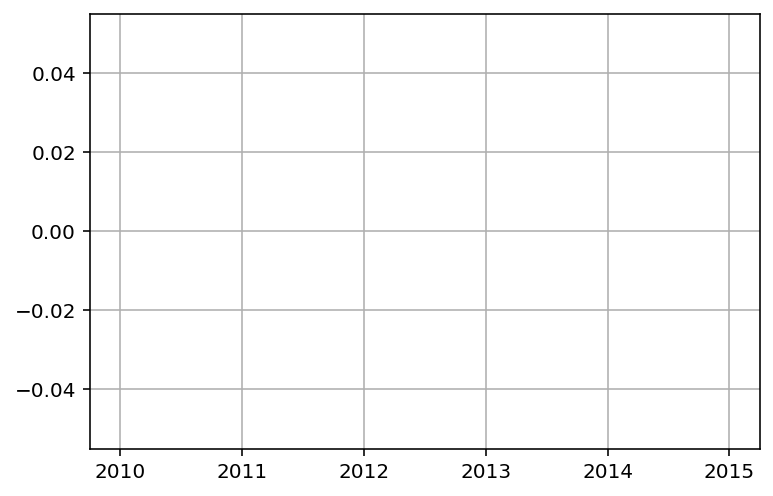

In [49]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2010-01-01'),pd.to_datetime('2014-12-31')))

In [50]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [51]:
# After analysis, it seems that we have minimal number of inspections before 2015
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2015-01-01')

In [52]:
sum(df['TO_DELETE'])

63919

### ACTION

In [53]:
sum(df.ACTION.isnull())

4067

In [54]:
df["ACTION"].value_counts()

Violations were cited in the following area(s).                                                                                       254913
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.     10172
Establishment re-opened by DOHMH.                                                                                                       2822
No violations were recorded at the time of this inspection.                                                                             2680
Establishment re-closed by DOHMH.                                                                                                         47
Name: ACTION, dtype: int64

In [55]:
df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
    inplace=True
)

In [56]:
df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations',
    inplace=True
)

In [57]:
df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed',
    inplace=True
)

In [58]:
df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
    inplace=True
)

In [59]:
df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',
    inplace=True
)

In [60]:
df["ACTION"].value_counts()

Violations found           254913
Establishment closed        10172
Establishment re-opened      2822
No violations                2680
Establishment re-closed        47
Name: ACTION, dtype: int64

In [61]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [62]:
sum(df['TO_DELETE'])

63919

### SCORE

In [63]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [64]:
df.SCORE.describe()

count    261815.000000
mean         21.413785
std          15.605163
min           0.000000
25%          11.000000
50%          17.000000
75%          27.000000
max         157.000000
Name: SCORE, dtype: float64

In [65]:
len(df)

274701

In [66]:
len( df[ df.SCORE < 0 ] )

0

In [67]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [68]:
sum(df['TO_DELETE'])

63919

In [69]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [70]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [71]:
sum(df['TO_DELETE'])

64011

### RECORD_DATE

In [72]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [73]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [74]:
df.GRADE.value_counts()

A    104043
B     15036
C      6381
N      6364
Z      3020
P      1407
G         1
Name: GRADE, dtype: int64

In [75]:
sum(df.GRADE.isnull())

138449

In [76]:
df.query(" GRADE == 'G' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
35993,50043665,MEXICO EN LA PIEL,Brooklyn,5904,5 AVENUE,11220,7187650001,Mexican,2019-11-08,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.639960133856,-74.015677529764,307,38,007400,3324492,3008630040,BK32,True


In [77]:
# Seems that all the "G" correspond to "A"
df.GRADE.replace('G', 'A', inplace=True)

In [78]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
561,50051965,LITTLE POLAND RESTAURANT,Manhattan,200,2 AVENUE,10003,2127779728,Polish,2017-11-16,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.731394216196,-73.985617855678,103,02,004000,1006479,1004540004,MN22,True
982,40786914,BOSTON MARKET,Staten Island,1465,FOREST AVENUE,10302,7188151198,American,2020-01-17,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.624525295465,-74.136709808322,501,49,024700,5024939,5010530124,SI28,True
1009,50074231,CHOPSTIX,Brooklyn,3790,NOSTRAND AVENUE,11235,7188910391,Chinese/Japanese,2019-10-15,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.591178949194,-73.940115495018,315,48,059600,3327489,3074450001,BK17,True
1085,50033801,BABBALUCCI'S,Manhattan,331,LENOX AVENUE,10027,6469186578,Italian,2018-12-13,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.808811380956,-73.944734230384,110,09,022400,1057866,1019110033,MN03,True
1206,41330647,MISS FAVELA,Brooklyn,57,SOUTH 5 STREET,11249,7182304040,Brazilian,2019-09-23,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.7121576202,-73.966428539688,301,33,054900,3063402,3024410032,BK73,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273291,50069505,TAJ MAHAL INDIAN REST,Brooklyn,7315,3 AVENUE,11209,7187096279,Indian,2019-03-28,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.632656835457,-74.027287650418,310,43,006600,3147843,3059180004,BK31,True
273463,50058097,CROWN FRIED CHICKEN,Brooklyn,148,UTICA AVENUE,11213,9179662500,Chicken,2019-10-15,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.673780611026,-73.930657130826,308,36,034500,3036040,3013600051,BK61,True
273517,50059321,EL NUEVO SALINAS BAR & RESTAURANT,Queens,10202,NORTHERN BLVD,11368,7182051980,Spanish,2017-12-18,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.757535339296,-73.866419993828,403,21,037900,4042582,4017170001,QN26,True
274061,41629759,PL LOUNGE RESTAURANT,Queens,38123816,65 STREET,NaN,6463265165,Latin American,2018-10-02,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,0,0,NaN,NaN,NaN,NaN,4,NaN,True


In [79]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

Establishment re-opened    1407
Name: ACTION, dtype: int64

In [80]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

Cycle Inspection / Reopening Inspection            1146
Pre-permit (Operational) / Reopening Inspection     261
Name: INSPECTION_TYPE, dtype: int64

In [81]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [82]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

# 
df.GRADE.value_counts()

A    104044
B     15036
C      6381
N      6364
Z      3020
P      1407
Name: GRADE, dtype: int64

In [83]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [84]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [85]:
# Grade date and inspection date should be the same. 
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [86]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [87]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [88]:
df.VIOLATION_CODE.isnull().sum()

6770

In [89]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

assert( len(check) == 0 )


In [90]:
df.VIOLATION_DESCRIPTION.isnull().sum()

5343

In [91]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False)


,VIOLATION_DESCRIPTION
VIOLATION_CODE,
16C,2
02A,1
15L,1
15J,1
15I,1
...,...
04O,1
04N,1
04M,1


In [92]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [93]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [94]:
df.VIOLATION_CODE.isnull().sum()

6770

In [95]:
## LATITUDE and LONGITUDE

In [96]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

### MISC analysis

In [97]:
# Find the unique values in each column
# 
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


False    207053
True      67648
Name: TO_DELETE, dtype: int64
=====
Critical          144160
Not Critical      125198
Not Applicable      5343
Name: CRITICAL_FLAG, dtype: int64
=====
Violations found           254913
Establishment closed        10172
Establishment re-opened      2822
No violations                2680
Establishment re-closed        47
Name: ACTION, dtype: int64
=====
Manhattan        105771
Brooklyn          67587
Queens            65566
Bronx             26910
Staten Island      8793
0                    74
Name: BORO, dtype: int64
=====
A    104044
B     15036
C      6381
N      6364
Z      3020
P      1407
Name: GRADE, dtype: int64
=====
Initial Inspection                                             160400
Re-inspection                                                   54254
Pre-permit (Operational) / Initial Inspection                   28148
Pre-permit (Operational) / Re-inspection                        10480
Administrative Miscellaneous / Initial Inspection      

In [98]:
df.dtypes

CAMIS                            object
DBA                              object
BORO                             object
BUILDING                         object
STREET                           object
ZIPCODE                          object
PHONE                            object
CUISINE_DESCRIPTION              object
INSPECTION_DATE          datetime64[ns]
ACTION                           object
VIOLATION_CODE                   object
VIOLATION_DESCRIPTION            object
CRITICAL_FLAG                    object
SCORE                           float64
GRADE                            object
INSPECTION_TYPE                  object
LATITUDE                        float64
LONGITUDE                       float64
COMMUNITY_BOARD                  object
COUNCIL_DISTRICT                 object
CENSUS_TRACT                     object
BIN                              object
BBL                              object
NTA                              object
TO_DELETE                          bool


## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [99]:
len(df)

274701

In [100]:
assert len(df) == initial_size

In [101]:
df = df[ df.TO_DELETE == False].copy()

In [102]:
len(df)

207053

In [103]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

201       Non-food contact surface improperly constructe...
202       Non-food contact surface improperly constructe...
223       Food not protected from potential source of co...
268                                                     NaN
747                                                     NaN
                                ...                        
273299    Food worker does not use proper utensil to eli...
273552           Hot food item not held at or above 140º F.
273639    Facility not vermin proof. Harborage or condit...
273836                                                  NaN
274351    Tobacco use, eating, or drinking from open con...
Name: VIOLATION_DESCRIPTION, Length: 794, dtype: object

In [104]:
profile

default


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/basic.py:300: UserWarning: %profile is now deprecated. Please use get_ipython().profile instead.
  warn("%profile is now deprecated. Please use get_ipython().profile instead.")


## Additional Data Quality Checks

In [105]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [106]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [107]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [108]:
assert sum(df.STREET.isnull()) == 0

In [109]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [110]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [111]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [112]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [113]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [114]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

201       Non-food contact surface improperly constructe...
202       Non-food contact surface improperly constructe...
223       Food not protected from potential source of co...
268                                                     NaN
747                                                     NaN
                                ...                        
273299    Food worker does not use proper utensil to eli...
273552           Hot food item not held at or above 140º F.
273639    Facility not vermin proof. Harborage or condit...
273836                                                  NaN
274351    Tobacco use, eating, or drinking from open con...
Name: VIOLATION_DESCRIPTION, Length: 794, dtype: object

## Normalization

### Violation Codes

In [115]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot food item not held at or above 140º F.,Critical
02C,Hot food item that has been cooked and refrige...,Critical
02D,Precooked potentially hazardous food from comm...,Critical
02E,"Whole frozen poultry or poultry breasts, other...",Critical
...,...,...
10J,Hand wash sign not posted,Not Critical
17A1,Dogs allowed sign not posted at or near the e...,Not Critical
19A1,Organics containers not provided,Not Critical


In [116]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot food item not held at or above 140º F.,Critical
02C,Hot food item that has been cooked and refrige...,Critical
02D,Precooked potentially hazardous food from comm...,Critical
02E,"Whole frozen poultry or poultry breasts, other...",Critical
...,...,...
10J,Hand wash sign not posted,Not Critical
17A1,Dogs allowed sign not posted at or near the e...,Not Critical
19A1,Organics containers not provided,Not Critical


In [117]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [118]:
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
0,41524890,LITTLE CUPCAKE BAKE SHOP,Manhattan,30,PRINCE STREET,10012,2129419100,Bakery Products/Desserts,2019-09-23,Establishment closed,...,Initial Inspection,40.722974,-73.994801,102,01,004300,1007478,1004930013,MN24,False
1,40387178,WHITE CASTLE,Bronx,550,EAST FORDHAM ROAD,10458,7185845310,Hamburgers,2019-02-06,Violations found,...,Initial Inspection,40.859181,-73.886619,206,15,038700,2011938,2030670012,BX06,False
2,40387178,WHITE CASTLE,Bronx,550,EAST FORDHAM ROAD,10458,7185845310,Hamburgers,2019-02-06,Violations found,...,Initial Inspection,40.859181,-73.886619,206,15,038700,2011938,2030670012,BX06,False
3,40387178,WHITE CASTLE,Bronx,550,EAST FORDHAM ROAD,10458,7185845310,Hamburgers,2019-02-06,Violations found,...,Initial Inspection,40.859181,-73.886619,206,15,038700,2011938,2030670012,BX06,False
4,50017360,MOZZARELLA,Brooklyn,264,LEE AVENUE,11206,7187835555,Jewish/Kosher,2017-02-13,Violations found,...,Initial Inspection,40.699892,-73.953697,301,33,053100,3387767,3022630048,BK75,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274695,50093362,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,Manhattan,2085,LEXINGTON AVENUE,10035,2127225253,Caribbean,2022-02-03,Violations found,...,Initial Inspection,40.804888,-73.937026,111,09,019600,1054487,1017740051,MN34,False
274696,41428580,BUON,Queens,7402,ELIOT AVENUE,11379,7184782200,Italian,2019-12-11,Violations found,...,Re-inspection,40.722063,-73.885515,405,30,066501,4067019,4029300001,QN21,False
274698,50045240,HUNAN BISTRO,Manhattan,96,3 AVENUE,10003,7186685271,Chinese,2022-03-08,Violations found,...,Initial Inspection,40.732281,-73.987927,103,02,004200,1084940,1005580032,MN22,False
274699,50055501,VANITY GENTLEMEN'S LOUNGE,Queens,7714,QUEENS BLVD,11373,9292084585,American,2019-02-23,Violations found,...,Initial Inspection,40.738365,-73.885880,404,25,047900,4056457,4024520007,QN50,False


### Restaurants

In [119]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [120]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE', 
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [121]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [122]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
0,41524890,LITTLE CUPCAKE BAKE SHOP,30,PRINCE STREET,10012,Manhattan,2129419100,Bakery Products/Desserts,40.722974,-73.994801,102,01,004300,1007478,1004930013,MN24
1,40387178,WHITE CASTLE,550,EAST FORDHAM ROAD,10458,Bronx,7185845310,Hamburgers,40.859181,-73.886619,206,15,038700,2011938,2030670012,BX06
4,50017360,MOZZARELLA,264,LEE AVENUE,11206,Brooklyn,7187835555,Jewish/Kosher,40.699892,-73.953697,301,33,053100,3387767,3022630048,BK75
5,50079684,KRAVE CHICKEN & BURGER,4035,21ST ST,11101,Queens,7187865571,Chicken,40.754735,-73.941697,401,26,003300,4004967,4004100001,QN68
6,40393561,FAROS RESTAURANT,95,CHURCH AVENUE,11218,Brooklyn,7184365449,American,40.642677,-73.979731,312,39,049600,3124485,3053320064,BK41


In [123]:
restaurants.PHONE.value_counts().head(20)

2124656273    43
9176186310    33
9172843260    29
2126159700    19
7186566210    17
2125867610    15
7182153308    15
__________    14
2125825472    14
2124656302    14
9177437388    11
2125325003     9
9178863304     8
7187011630     8
7182246030     8
2123544624     7
2123959280     7
9175665727     7
6465881074     7
2129818588     7
Name: PHONE, dtype: int64

In [124]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [125]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [126]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [127]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

In [128]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [129]:
df = df.drop (columns[1:], axis='columns')

In [130]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
0,41524890,2019-09-23,Establishment closed,08A,44.0,NaN,Initial Inspection,False
1,40387178,2019-02-06,Violations found,10F,9.0,A,Initial Inspection,False
2,40387178,2019-02-06,Violations found,10F,9.0,A,Initial Inspection,False
3,40387178,2019-02-06,Violations found,10F,9.0,A,Initial Inspection,False
4,50017360,2017-02-13,Violations found,10F,22.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...,...
274695,50093362,2022-02-03,Violations found,10B,29.0,NaN,Initial Inspection,False
274696,41428580,2019-12-11,Violations found,08A,12.0,A,Re-inspection,False
274698,50045240,2022-03-08,Violations found,06A,33.0,NaN,Initial Inspection,False
274699,50055501,2019-02-23,Violations found,08A,20.0,NaN,Initial Inspection,False


### Inspections

In [131]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [132]:
inspection

,CAMIS,INSPECTION_DATE,ACTION,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
9297,41030982,2015-04-03,Violations found,34.0,NaN,Initial Inspection,False
106662,41030982,2015-05-14,Violations found,9.0,A,Re-inspection,False
6020,41171220,2015-06-25,Violations found,10.0,NaN,Initial Inspection,False
39988,41171220,2015-07-08,Violations found,13.0,A,Re-inspection,False
37580,50000233,2015-07-29,Violations found,11.0,A,Re-inspection,False
...,...,...,...,...,...,...,...
25846,50096401,2022-06-21,Violations found,33.0,NaN,Initial Inspection,False
58688,50099342,2022-06-21,Violations found,13.0,A,Initial Inspection,False
94287,50100420,2022-06-21,Violations found,12.0,A,Re-inspection,False
143053,50104121,2022-06-21,Violations found,9.0,A,Initial Inspection,False


In [133]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [134]:
inspection.ACTION.value_counts()

Violations found        62508
Establishment closed     1168
No violations             418
Name: ACTION, dtype: int64

In [135]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2


In [136]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [137]:
# to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]
# inspection = inspection.drop(to_drop, axis='index')

In [138]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

In [139]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [140]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

In [141]:
inspection.INSPECTION_TYPE.value_counts()

Initial Inspection    46049
Re-inspection         18044
Name: INSPECTION_TYPE, dtype: int64

In [142]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

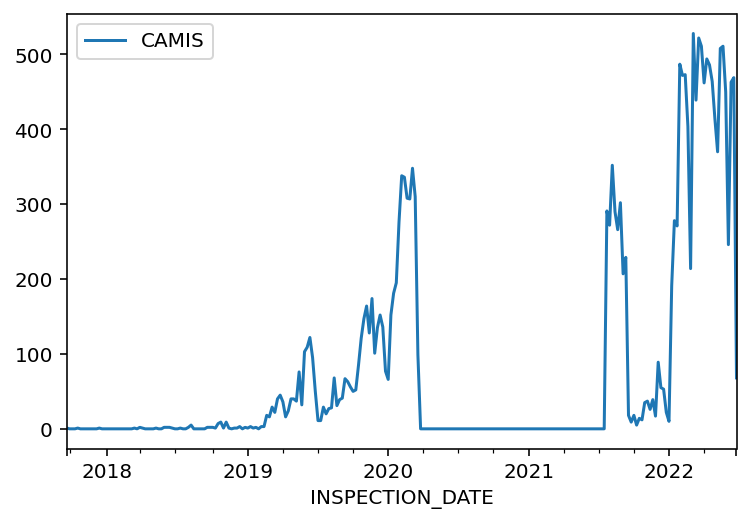

In [143]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [144]:
# Longevity 
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

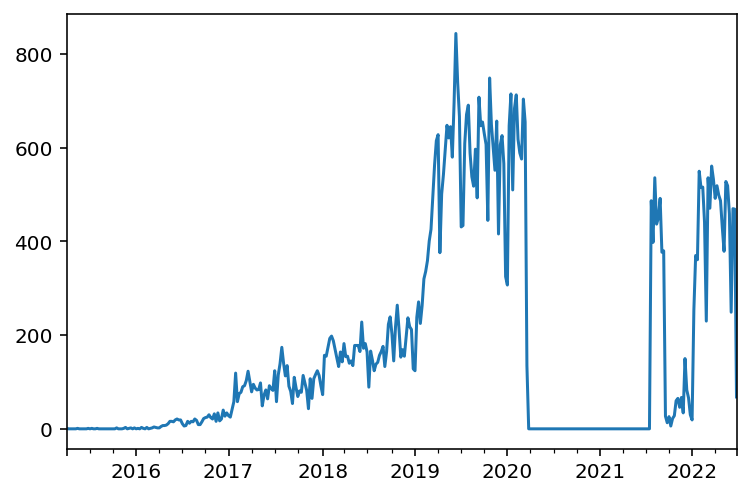

In [145]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [146]:
len(df)

207053

In [147]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

193908

In [148]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 193908
Inspections: 64093
Restaurants: 18819
Violation Codes: 68


## Storing in MySQL


In [149]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 1.6 MB 8.9 MB/s 


In [150]:
import os
from sqlalchemy import create_engine

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'root',
    password = 'ae6jQniBS5muV27', #os.environ['MYSQL_PASSWORD'],
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [156]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
engine.execute(sql)

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
engine.execute(sql)

# And lets switch to the database
sql = f"USE {db_name}"
engine.execute(sql)

In [157]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(90), 
    BUILDING varchar(10), 
    STREET varchar(40), 
    ZIPCODE char(5), 
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10), 
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4), 
PRIMARY KEY(CAMIS)   
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               char(8),
    CAMIS                      char(8),
    INSPECTION_DATE    datetime,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID) 
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(4),
  DESCRIPTION varchar(300),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical'),
  PRIMARY KEY(VIOLATION_CODE) 

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         char(8),
  VIOLATION_CODE     char(4),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID),
FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

In [158]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [159]:
restaurants.to_sql(
        name = 'restaurants', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [160]:
inspection.to_sql(
        name = 'inspections', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [161]:
violations.to_sql(
        name = 'violations', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [162]:
sql = '''
GRANT SELECT ON doh_restaurants.* TO 'student'@'%%'
'''
engine.execute(sql)

In [ ]:


sql = '''
CREATE VIEW restaurant_inspection_latest AS 
	WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE, V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
      '''

engine.execute(sql)